<a href="https://colab.research.google.com/github/Matteo-Salis/CIWA-net/blob/main/CIWA_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages, libraries & data loading

In [ ]:
!pip install rioxarray
!pip install cftime
!pip install netCDF4
!pip install keras
!pip install descartes

In [ ]:
# import libraries
import numpy as np
import rioxarray
import matplotlib.pyplot as plt
import xarray
from netCDF4 import num2date
import pandas as pd
import numpy as np
import copy
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import tensorflow as tf
from tensorflow.keras import activations
import pickle

In [ ]:
# connecting to drive: download all the file and upload on your gdrive!
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
# paths: select your own!
era5_path = "/gdrive/MyDrive/Sensors/Data/Meteorology/era5_ds_reprojected.nc"
grace_path = "/gdrive/MyDrive/Sensors/Data/GRACE/grace_ds_interpolated.nc"
era5_ds = xarray.open_dataset(era5_path) # reading ERA5 file
grace_ds = xarray.open_dataset(grace_path) # reading GRACE file

In [ ]:
era5_ds = era5_ds.drop_vars(('spatial_ref','slt', 'cvh', 'cvl', 'tvh', 'tvl')) # drop unecessary variables

 Visualization examples

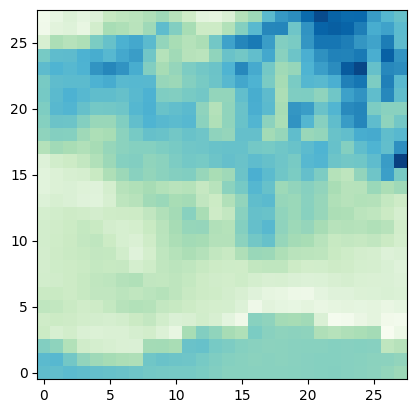

In [ ]:
fig= plt.imshow(np.array(era5_ds["e"][-8]), cmap = 'GnBu', origin = "lower" )
#fig.axes.get_xaxis().set_visible(False) axis represent coordinate
#fig.axes.get_yaxis().set_visible(False)

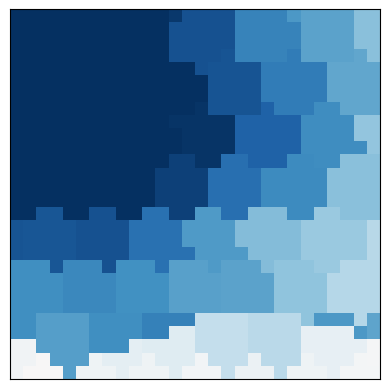

In [ ]:
fig= plt.imshow(np.array(grace_ds.isel(time=15).to_array())[0], origin = "lower", cmap = 'RdBu', vmax = 12, vmin = -12)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

# Preprocessing

In [ ]:
# save scaling factors
era5_ds_mean = era5_ds.mean()
era5_ds_sd = era5_ds.std()
grace_ds_mean = grace_ds.mean()
grace_ds_std = grace_ds.std()
grace_ds_min = grace_ds.min()
grace_ds_max = grace_ds.max()

In [ ]:
era5_ds_min = era5_ds.min()
era5_ds_max = era5_ds.max()
era5_ds_range = era5_ds_max - era5_ds_min

In [ ]:
# standardize ERA5 dataset
era5_std = copy.deepcopy(era5_ds)
era5_std = (era5_std - era5_ds_mean) / era5_ds_sd

In [ ]:
#standardize GRACE for delayed input

grace_std = copy.deepcopy(grace_ds)
grace_std = (grace_std - grace_ds_mean) / grace_ds_std

# # normalize GRACE dataset
grace_norm = copy.deepcopy(grace_ds)
grace_norm = (grace_norm - grace_ds_min) / (grace_ds_max - grace_ds_min)

## create separate numpy array per each month

In [ ]:
# prepare dataset (# month, x dim, y dim, channel)
# Y: GRACE data (channel = 1)
# X: ERA5 data (channel = 10) + GRACE delay (add delta channels)

n_grace_delay = 2 # 1 for grace at the same time of era5, >1 more delays respect to era5
n_era5_delay = 1 # how many time step haed the prediction is done
T_original = era5_ds.time.shape[0] # all the time steps
total_delay = (n_era5_delay+n_grace_delay-1) if n_grace_delay > 0 else (n_era5_delay+n_grace_delay)
T = T_original - total_delay
 # max time steps of the features given the shift between X and Y (n_era5_delay) and grace delay

X = np.zeros((T,28,28,(10 + n_grace_delay))) # n_grace_delay: month of delaied Grace
Y = np.zeros((T,28,28,1)) # it will be shifted ahaed by n_era5_delay times

In [ ]:
i = 1
tmp = np.array(era5_std.isel(time=i).to_array())
for j in (range(n_grace_delay)):
  tmp = np.append(tmp, grace_std.isel(time=(i-j)).to_array(), axis = 0)

tmp.shape

(12, 28, 28)

In [ ]:
for i in (range((max(n_grace_delay-1,0)),T_original - 1)): # T_original -1 because we will predict the last value of grace with the values of X in the last-1 month
# n_grace_delay-1 because index start from 0

  tmp = np.array(era5_std.isel(time=i).to_array()) # append grace at the same month of era5

  for j in (range(n_grace_delay)):
    tmp = np.append(tmp, grace_std.isel(time=(i-j)).to_array(), axis = 0)

  X[i-max((n_grace_delay-1),0)] = tmp.transpose((1,2,0))

In [ ]:
for i in range(max(n_grace_delay,n_era5_delay),T_original): ## ptoblema con T_original
  tmp = np.array(grace_norm.isel(time=i).to_array()[0])
  Y[i-max(n_grace_delay,n_era5_delay)] = tmp.reshape(28,28,1)

In [ ]:
print(f"The shape of X is {X.shape} and Y is {Y.shape}")

The shape of X is (177, 28, 28, 12) and Y is (177, 28, 28, 1)


In [ ]:
# https://keras.io/examples/vision/conv_lstm/
#
# Vanilla CNN

# model construction
# Construct the input layer with no definite frame size.
input = layers.Input(shape=( 28, 28, (10 + n_grace_delay)))

#initializer = tf.keras.initializers.HeUniform

x = layers.Conv2D(32, (3,3), padding='same', activation = 'relu')(input)
#x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3,3), padding='same', activation = 'relu')(x)
#x = layers.PReLU()(x)
#x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(x)
#x = layers.PReLU()(x)
#x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(x)
#x = layers.PReLU()(x)
#x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation = 'relu')(x)
#x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3,3), padding='same', activation = 'relu')(x)
#x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation = 'relu')(x)
#x = layers.PReLU()(x)
#x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(x)
#x = layers.PReLU()(x)
#x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, (3,3), padding='same', activation = 'relu')(x)
#x = layers.PReLU()(x)
#x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(32, (3,3), padding='same', activation = 'relu')(x)
#x = layers.PReLU()(x)
x = layers.Flatten()(x)
# x = layers.Dropout(0.1)(x)
# x = layers.BatchNormalization()(x)
x = layers.Dense((28*28), activation='sigmoid')(x)

x = layers.Reshape((28,28))(x)


# Next, we will build the complete model and compile it.
model_CNN = keras.models.Model(input, x)
model_CNN.compile(
    loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ['MeanSquaredError','MeanAbsoluteError']
)


In [ ]:
# https://www.machinelearningnuggets.com/implementing-fully-convolutional-networks-fcns-from-scratch-in-keras-and-tensorflow/
#
# FCN

input = layers.Input(shape=( 28, 28, (10 + n_grace_delay)))

initializer = tf.keras.initializers.HeUniform

c0_1 = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(input) #output 28x28
#c0_1 = layers.PReLU()(c0_1)
c0_1 = layers.BatchNormalization()(c0_1)

c0_2 = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(c0_1) #output 28x28
#c0_2 = layers.PReLU()(c0_2)
c0_2 = layers.BatchNormalization()(c0_2)

c0_3 = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(c0_2) #output 28x28
#c0_3 = layers.PReLU()(c0_3)
c0_3 = layers.BatchNormalization()(c0_3)

c0_4 = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(c0_3) #output 28x28
#c0_4 = layers.PReLU()(c0_4)
c0_4 = layers.BatchNormalization()(c0_4)

c0_5 = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(c0_4) #output 28x28
#c0_5 = layers.PReLU()(c0_5)
c0_5 = layers.BatchNormalization()(c0_5)

c0_6 = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(c0_5) #output 28x28
#c0_6 = layers.PReLU()(c0_6)
c0_6 = layers.BatchNormalization()(c0_6)

c0_7 = layers.Conv2D(128, (3,3), padding='same', activation = 'relu')(c0_6) #output 28x28
#c0_7 = layers.PReLU()(c0_7)
c0_7 = layers.BatchNormalization()(c0_7)

c1_1 = layers.Conv2D(128, (2,2), strides = 2, padding='same', activation = 'relu')(c0_7) # output 14x14
#c1_1 = layers.PReLU()(c1_1)
c1_1 = layers.BatchNormalization()(c1_1)

c1_2 = layers.Conv2D(128, (2,2), padding='same', activation = 'relu')(c1_1) # output 14x14
#c1_2 = layers.PReLU()(c1_2)
c1_2 = layers.BatchNormalization()(c1_2)

c1_3 = layers.Conv2D(256, (2,2), padding='same', activation = 'relu')(c1_2) # output 14x14
#c1_3 = layers.PReLU()(c1_3)
c1_3 = layers.BatchNormalization()(c1_3)

c1_4 = layers.Conv2D(256, (2,2), padding='same', activation = 'relu')(c1_3) # output 14x14
#c1_4 = layers.PReLU()(c1_4)
c1_4 = layers.BatchNormalization()(c1_4)

c1_5 = layers.Conv2D(256, (2,2), padding='same', activation = 'relu')(c1_4) # output 14x14
#c1_5 = layers.PReLU()(c1_5)
c1_5 = layers.BatchNormalization()(c1_5)

c2_1 = layers.Conv2D(512, (2,2), strides = 2, padding='same', activation = 'relu')(c1_5) # output 7x7
#c2_1 = layers.PReLU()(c2_1)
c2_1 = layers.BatchNormalization()(c2_1)

# stop downsample
c2_2 = layers.Conv2D(512, (2,2), padding='same', activation = 'relu')(c2_1) # output 7x7
#c2_2 = layers.PReLU()(c2_2)
c2_2 = layers.BatchNormalization()(c2_2)

c2_3 = layers.Conv2D(512, (2,2), padding='same', activation = 'relu')(c2_2) # output 7x7
#c2_3 = layers.PReLU()(c2_3)
c2_3 = layers.BatchNormalization()(c2_3)

c2_4 = layers.Conv2D(512, (2,2), padding='same', activation = 'relu')(c2_3) # output 7x7
#c2_4 = layers.PReLU()(c2_4)
c2_4 = layers.BatchNormalization()(c2_4)

c2_5 = layers.Conv2D(512, (2,2), padding='same', activation = 'relu')(c2_4) # output 7x7
#c2_5 = layers.PReLU()(c2_5)
c2_5 = layers.BatchNormalization()(c2_5)

c2_6 = layers.Conv2D(512, (2,2), padding='same', activation = 'relu')(c2_5) # output 7x7
#c2_5 = layers.PReLU()(c2_6)
c2_5 = layers.BatchNormalization()(c2_6)

# start upsample
u1_1 = layers.Conv2DTranspose(256, (2, 2), strides=(2,2), padding='same', activation = 'relu')(c2_6) # output 14x14
#u1_1 = layers.PReLU()(u1_1)
u1_1 = layers.BatchNormalization()(u1_1)

add1 = layers.Add()([u1_1, c1_5])
add1 = layers.Activation(activations.relu)(add1)

u1_2 = layers.Conv2DTranspose(256, (2, 2), padding='same', activation = 'relu')(add1) # output 14x14
#u1_2 = layers.PReLU()(u1_2)
u1_2 = layers.BatchNormalization()(u1_2)

u1_3 = layers.Conv2DTranspose(256, (2, 2), padding='same', activation = 'relu')(u1_2) # output 14x14
#u1_3 = layers.PReLU()(u1_3)
u1_3 = layers.BatchNormalization()(u1_3)

u1_4 = layers.Conv2DTranspose(128, (2, 2), padding='same', activation = 'relu')(u1_3) # output 14x14
#u1_4 = layers.PReLU()(u1_4)
u1_4 = layers.BatchNormalization()(u1_4)

u1_5 = layers.Conv2DTranspose(128, (2, 2), padding='same', activation = 'relu')(u1_4) # output 14x14
#u1_5 = layers.PReLU()(u1_5)
u1_5 = layers.BatchNormalization()(u1_5)

u2_1 = layers.Conv2DTranspose(128, (2, 2), strides=2, padding='same', activation = 'relu')(u1_5) # output 28x28
#u2_1 = layers.PReLU()(u2_1)
u2_1 = layers.BatchNormalization()(u2_1)

add2 = layers.Add()([u2_1, c0_7])
add2 = layers.Activation(activations.relu)(add2)

u3_1 = layers.Conv2DTranspose(128, (3,3), padding='same', activation = 'relu')(add2) # output 28x28
#u3_1 = layers.PReLU()(u3_1)
u3_1 = layers.BatchNormalization()(u3_1)

u3_2 = layers.Conv2DTranspose(128, (3,3), padding='same', activation = 'relu')(u3_1) # output 28x28
#u3_2 = layers.PReLU()(u3_2)
u3_2 = layers.BatchNormalization()(u3_2)

u3_3 = layers.Conv2DTranspose(128, (3,3), padding='same', activation = 'relu')(u3_2) # output 28x28
#u3_3 = layers.PReLU()(u3_3)
u3_3 = layers.BatchNormalization()(u3_3)

u3_4 = layers.Conv2DTranspose(128, (3,3), padding='same', activation = 'relu')(u3_3) # output 28x28
#u3_4 = layers.PReLU()(u3_4)
u3_4 = layers.BatchNormalization()(u3_4)

add3 = layers.Add()([u3_4, c0_3])
add3 = layers.Activation(activations.relu)(add3)

u3_5 = layers.Conv2DTranspose(128, (3,3), padding='same', activation = 'relu')(add3) # output 28x28
#u3_5 = layers.PReLU()(u3_5)
u3_5 = layers.BatchNormalization()(u3_5)

u3_6 = layers.Conv2DTranspose(128, (3,3), padding='same', activation = 'relu')(u3_5) # output 28x28
#u3_6 = layers.PReLU()(u3_6)
u3_6 = layers.BatchNormalization()(u3_6)

u3_7 = layers.Conv2DTranspose(128, (3,3), padding='same', activation = 'relu')(u3_6) # output 28x28
#u3_7 = layers.PReLU()(u3_7)
u3_7 = layers.BatchNormalization()(u3_7)

u3_8 = layers.Conv2DTranspose(64, (3,3), padding='same', activation = 'relu')(u3_7) # output 28x28
#u3_8 = layers.PReLU()(u3_8)
u3_8 = layers.BatchNormalization()(u3_8)

out = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(u3_8) # output 28x28

model_FCN = keras.models.Model(input, out)
model_FCN.compile(
    loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ['MeanSquaredError','MeanAbsoluteError']
)

In [ ]:
model_CNN.summary()

In [ ]:
model_FCN.summary()

## Split training and test

In [ ]:
shift_grace_delay = (n_grace_delay -1) if n_grace_delay > 0 else n_grace_delay

In [ ]:
split = int(np.ceil((179-n_era5_delay)*0.85)); split

152

In [ ]:
actual_split = split-shift_grace_delay; actual_split

151

In [ ]:
# Xt predict yt+1
x_train = X[:actual_split] #before fixed at 151
y_train = Y[:actual_split]
x_val = X[actual_split:] #before fixed at 151
y_val = Y[actual_split:]

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(151, 28, 28, 12)
(26, 28, 28, 12)
(151, 28, 28, 1)
(26, 28, 28, 1)


# Training

## CNN model

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=70)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)

# Define modifiable training hyperparameters.
epochs = 500
batch_size = 4

# Fit the model to the training data.
history_2_CNN = model_CNN.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

In [ ]:
# save results
filename_CNN = '/gdrive/MyDrive/Sensors/Scripts/Grace/Models/'+'CNN_delay_'+str(n_grace_delay)+'.keras'
model_CNN.save(filename_CNN)

## CIWA-net model

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=70)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)

# Define modifiable training hyperparameters.
epochs = 500
batch_size = 4

# Fit the model to the training data.
history_2_FCN = model_FCN.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

In [ ]:
# save results
filename_FCN = '/gdrive/MyDrive/Sensors/Scripts/Grace/Models/'+'FCN_delay_'+str(n_grace_delay)+'.keras'
model_FCN.save(filename_FCN)

# Prediction
 here we load our CIWA-net pre-trained model

In [ ]:
best_model = keras.models.load_model('/gdrive/MyDrive/Sensors/Scripts/Grace/Models/'+'FCN_delay_'+str(2)+'.keras')
Y_pred_best = best_model.predict(X)

6/6 [==============================] - 10s 109ms/step


In [ ]:
# plotting prediction examples
y = Y[0]
y.shape

(28, 28, 1)

In [ ]:
y_pred_best = Y_pred_best[0]
y_pred_best.shape

(28, 28, 1)

Text(0.5, 1.0, 'Training truth')

<Figure size 640x480 with 0 Axes>

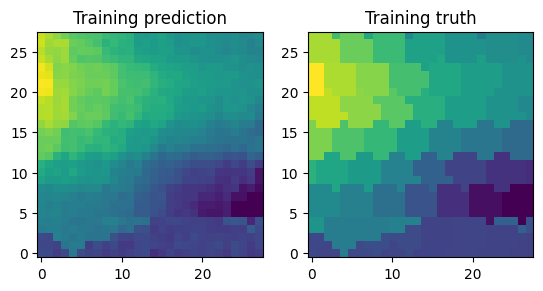

In [ ]:
plt.figure()

f, axarr = plt.subplots(1,2)

axarr[0].imshow(y_pred_best, origin="lower", vmin = y.min(), vmax = y.max())
axarr[0].set_title('Training prediction')

axarr[1].imshow(y, origin="lower", vmin = y.min(), vmax = y.max())
axarr[1].set_title('Training truth')

<Figure size 640x480 with 0 Axes>

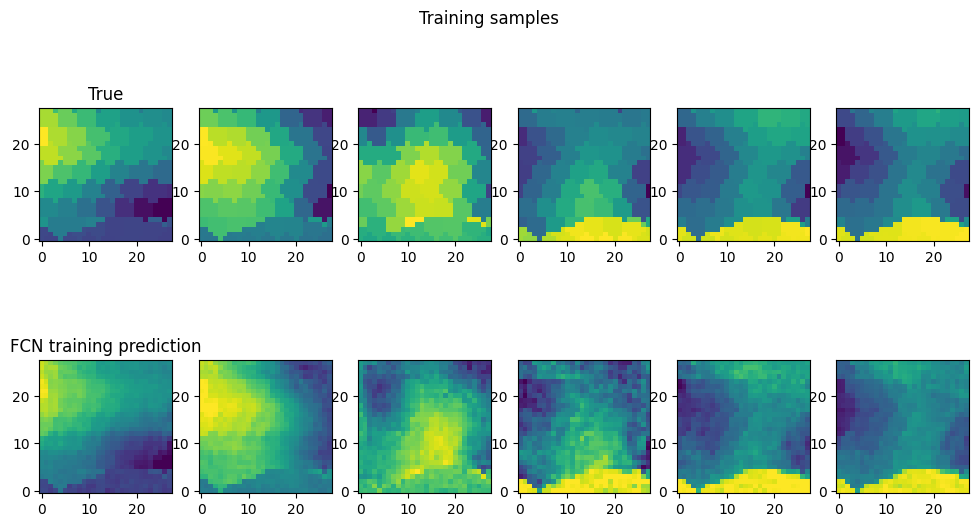

In [ ]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,6,figsize=(12, 6))
f.suptitle('Training samples')

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(Y[0], origin="lower")
axarr[0,0].set_title('True')
axarr[0,1].imshow(Y[1], origin="lower")
axarr[0,2].imshow(Y[2], origin="lower")
axarr[0,3].imshow(Y[3], origin="lower")
axarr[0,4].imshow(Y[4], origin="lower")
axarr[0,5].imshow(Y[5], origin="lower")

axarr[1,0].imshow(Y_pred_best[0], origin="lower", vmin = Y[0].min(), vmax = Y[0].max())
axarr[1,0].set_title('FCN training prediction')
axarr[1,1].imshow(Y_pred_best[1], origin="lower", vmin = Y[1].min(), vmax = Y[1].max())
axarr[1,2].imshow(Y_pred_best[2], origin="lower", vmin = Y[2].min(), vmax = Y[2].max())
axarr[1,3].imshow(Y_pred_best[3], origin="lower", vmin = Y[3].min(), vmax = Y[3].max())
axarr[1,4].imshow(Y_pred_best[4], origin="lower", vmin = Y[4].min(), vmax = Y[4].max())
axarr[1,5].imshow(Y_pred_best[5], origin="lower", vmin = Y[5].min(), vmax = Y[5].max())

Re-scale the output

<ipython-input-26-c15448abdf46>:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout(pad=0.5)


<Figure size 640x480 with 0 Axes>

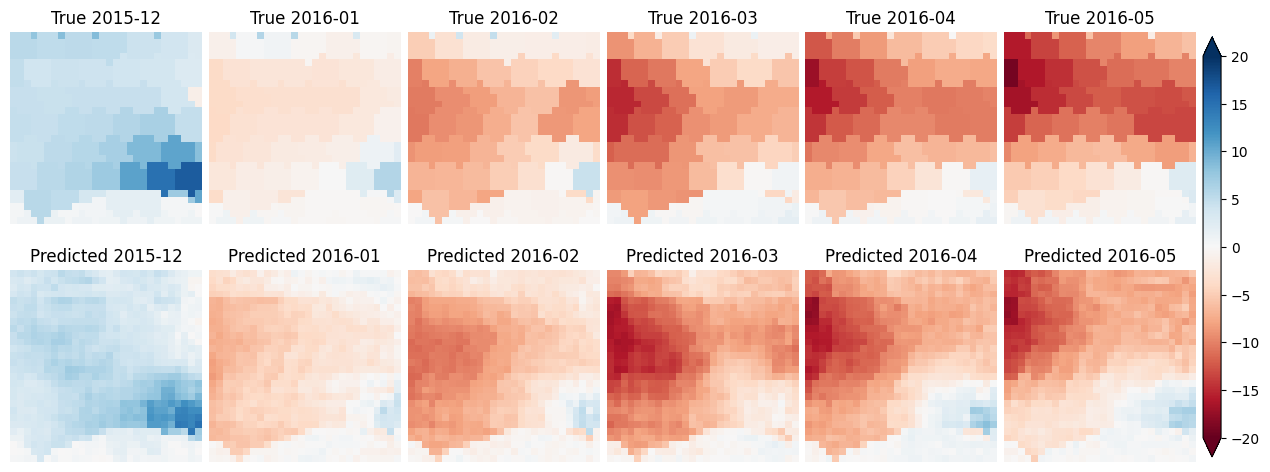

In [ ]:
# rescaled output

Y_rescaled = (Y*(float(grace_ds_max['lwe_thickness'].values) - float(grace_ds_min['lwe_thickness'].values))) + float(grace_ds_min['lwe_thickness'].values)
Y_pred_rescaled = (Y_pred_best*(float(grace_ds_max['lwe_thickness'].values) - float(grace_ds_min['lwe_thickness'].values))) + float(grace_ds_min['lwe_thickness'].values)

Y_true = Y_rescaled # otherwise Y
Y_predicted = Y_pred_rescaled # otherwise Y_pred

last = -15 # in the image (the younger)
first = -19
vmin = -20#Y_true[first:last].min()
vmax = 20#Y_true[first:last].max()

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,6,figsize=(12, 6))
#f.suptitle('True images')

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
prova = axarr[0,5].imshow(Y_true[first+5], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[0,5].set_title('True '+str(grace_ds["time"][first+5].dt.strftime("%Y-%m").values))
axarr[0,5].axis('off')

axarr[0,4].imshow(Y_true[first+4], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[0,4].set_title('True '+str(grace_ds["time"][first+4].dt.strftime("%Y-%m").values))
axarr[0,4].axis('off')

axarr[0,3].imshow(Y_true[first+3], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[0,3].set_title('True '+str(grace_ds["time"][first+3].dt.strftime("%Y-%m").values))
axarr[0,3].axis('off')

axarr[0,2].imshow(Y_true[first+2], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[0,2].set_title('True '+str(grace_ds["time"][first+2].dt.strftime("%Y-%m").values))
axarr[0,2].axis('off')

axarr[0,1].imshow(Y_true[first+1], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[0,1].set_title('True '+str(grace_ds["time"][first+1].dt.strftime("%Y-%m").values))
axarr[0,1].axis('off')

axarr[0,0].imshow(Y_true[first], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[0,0].set_title('True '+str(grace_ds["time"][first].dt.strftime("%Y-%m").values))
axarr[0,0].axis('off')

#f.suptitle('Predicted images')

axarr[1,5].imshow(Y_predicted[first+5], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[1,5].set_title('Predicted '+str(grace_ds["time"][first+5].dt.strftime("%Y-%m").values))
axarr[1,5].axis('off')

axarr[1,4].imshow(Y_predicted[first+4], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[1,4].set_title('Predicted '+str(grace_ds["time"][first+4].dt.strftime("%Y-%m").values))
axarr[1,4].axis('off')

axarr[1,3].imshow(Y_predicted[first+3], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[1,3].set_title('Predicted '+str(grace_ds["time"][first+3].dt.strftime("%Y-%m").values))
axarr[1,3].axis('off')

axarr[1,2].imshow(Y_predicted[first+2], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[1,2].set_title('Predicted '+str(grace_ds["time"][first+2].dt.strftime("%Y-%m").values))
axarr[1,2].axis('off')

axarr[1,1].imshow(Y_predicted[first+1], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[1,1].set_title('Predicted '+str(grace_ds["time"][first+1].dt.strftime("%Y-%m").values))
axarr[1,1].axis('off')

axarr[1,0].imshow(Y_predicted[first], origin="lower", vmin = vmin, vmax = vmax, cmap = 'RdBu')
axarr[1,0].set_title('Predicted '+str(grace_ds["time"][first].dt.strftime("%Y-%m").values))
axarr[1,0].axis('off')

f.colorbar(prova, cax=plt.axes([1, 0.15, 0.015, 0.7]), location='right', shrink=0.6, extend = 'both')

#f.clim([Y_true[-12:-7].min(), Y_true[-12:-7].max()])

plt.subplots_adjust(hspace=-0.3)
f.tight_layout(pad=0.5)

#axarr[0.0].get_xaxis().set_visible(False)

# Compute errors

## Mean time series

In [ ]:
# not normalized

best_prediction = Y_pred_rescaled[actual_split:,:,:,0] # on the validation
true_values = Y_rescaled[actual_split:,:,:,0]

In [ ]:
mean_per_time = np.mean(true_values, axis = (1,2))
pred_per_time = np.mean(best_prediction, axis = (1,2))
abs_diff_per_time = np.abs(mean_per_time - pred_per_time)

In [ ]:
range_per_time = np.ones((26))
for i in range(0,26):
 range_per_time[i] = (true_values[i,:,:].max()-true_values[i,:,:].min())

In [ ]:
error_date = grace_ds['time'][-26:].values

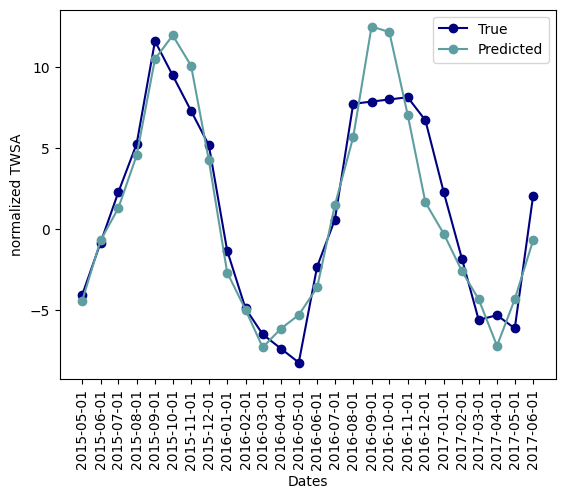

In [ ]:
plt.plot(error_date,mean_per_time, color = 'navy', marker = 'o', label = "True")
plt.plot(error_date,pred_per_time, color = 'cadetblue', marker = 'o', label = "Predicted")
plt.xticks(error_date,rotation = 90)
plt.ylabel("normalized TWSA") # non normalized [cm]
plt.xlabel("Dates")
plt.legend()

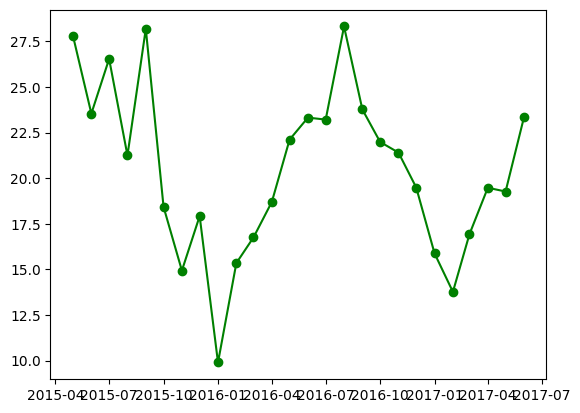

In [ ]:
plt.plot(error_date,range_per_time, color = 'green', marker = 'o')

## MAE and RMSE time series


In [ ]:
sum_of_squares=(best_prediction - true_values)**2
mse_per_time = np.mean(sum_of_squares, axis = (1,2))
rmse_per_time = np.sqrt(mse_per_time)

absolute_error = np.abs(best_prediction - true_values)
mae_per_time = np.mean(absolute_error, axis = (1,2))

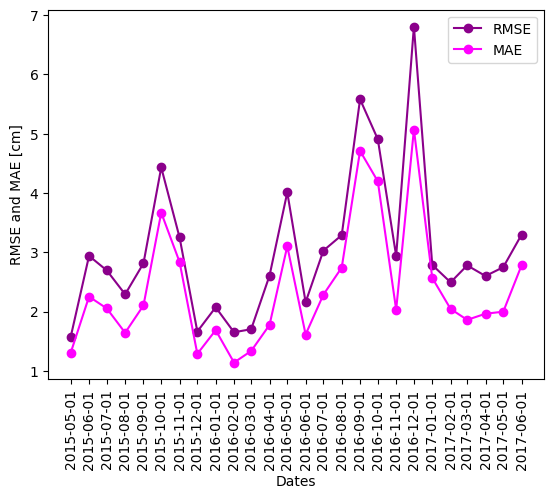

In [ ]:
plt.plot(error_date,rmse_per_time, color = 'darkmagenta', marker = 'o', label = "RMSE")
plt.plot(error_date,mae_per_time, color = 'magenta', marker = 'o', label = "MAE")
plt.xticks(error_date,rotation = 90)
plt.ylabel("RMSE and MAE [cm]") #and Mean Absolute Error (MAE)
plt.xlabel("Dates")
plt.legend()

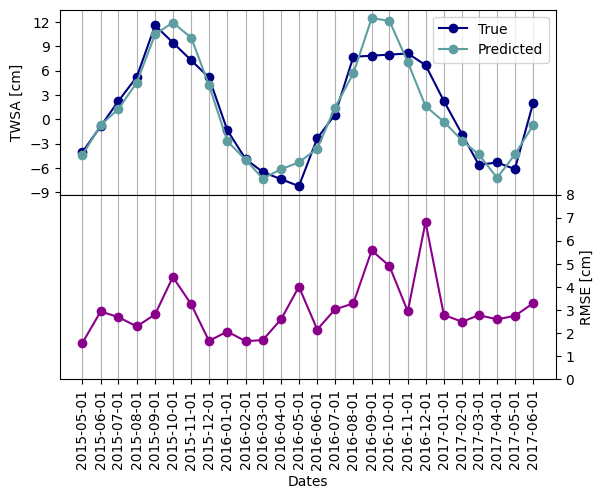

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

#fig.suptitle('True and predicted average TWSA & RMSE')

axs[0].plot(error_date,mean_per_time, color = 'navy', marker = 'o', label = "True")
axs[0].plot(error_date,pred_per_time, color = 'cadetblue', marker = 'o', label = "Predicted")
#axs[0].set_title('True and Prediction TWSA average series')
axs[0].set_yticks((-9,-6,-3,0,3,6,9,12))
axs[0].set_xticks(error_date)
axs[0].tick_params(axis='x', rotation=90)
axs[0].set(xlabel = "Dates", ylabel = "TWSA [cm]")
axs[0].grid(axis="x")
axs[0].legend()

axs[1].plot(error_date,rmse_per_time, color = 'darkmagenta', marker = 'o', label = "RMSE")
#axs[1].plot(error_date,mae_per_time, color = 'magenta', marker = 'o', label = "MAE")

#axs[1].set_title('RMSE series')
axs[1].set_yticks((0,1,2,3,4,5,6,7,8))
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_xticks(error_date)
axs[1].tick_params(axis='x', rotation=90)
axs[1].set(xlabel = "Dates", ylabel = "RMSE [cm]") #and MAE
axs[1].grid(axis="x")


## Percentage error (NRMSE)

In [ ]:
nrmse_range = np.divide(rmse_per_time,np.abs(range_per_time))*100

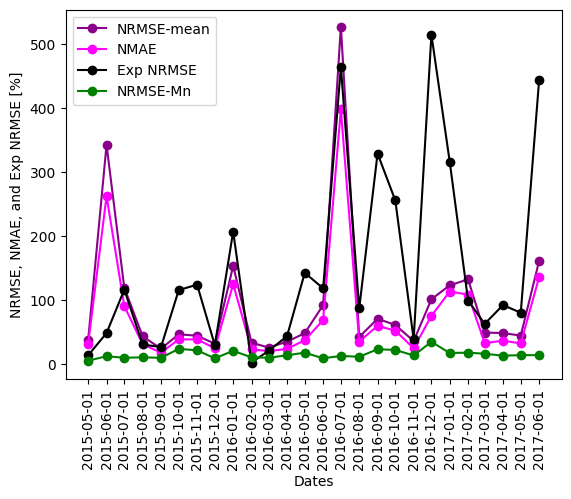

In [ ]:
plt.plot(error_date,nrmse_range, color = 'green', marker = 'o', label = "NRMSE-Mn")
plt.xticks(error_date,rotation = 90)
plt.ylabel("NRMSE[%]")
plt.xlabel("Dates")
plt.legend()

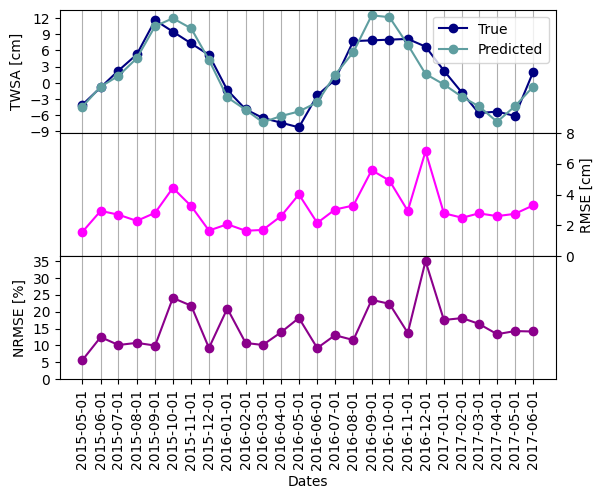

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)


axs[0].plot(error_date,mean_per_time, color = 'navy', marker = 'o', label = "True")
axs[0].plot(error_date,pred_per_time, color = 'cadetblue', marker = 'o', label = "Predicted")
#axs[0].set_title('True and Prediction TWSA average series')
axs[0].set_yticks((-9,-6,-3,0,3,6,9,12))
axs[0].set_xticks(error_date)
axs[0].tick_params(axis='x', rotation=90)
axs[0].set(xlabel = "Dates", ylabel = "TWSA [cm]")
axs[0].grid(axis="x")
axs[0].legend()

axs[1].plot(error_date,rmse_per_time, color = 'magenta', marker = 'o')
#axs[1].set_title('RMSE series')
axs[1].set_yticks((0,2,4,6,8))
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_xticks(error_date)
axs[1].tick_params(axis='x', rotation=90)
axs[1].set(xlabel = "Dates", ylabel = "RMSE [cm]")
axs[1].grid(axis="x")

axs[2].plot(error_date,nrmse_range, color = 'darkmagenta', marker = 'o')
axs[2].set_yticks((0,5,10,15,20,25,30,35))
axs[2].set_xticks(error_date)
axs[2].tick_params(axis='x', rotation=90)
axs[2].set(xlabel = "Dates", ylabel = "NRMSE [%]")
axs[2].grid(axis="x")

In [ ]:
np.median(nrmse_range)

13.827337936218292

In [ ]:
np.mean(nrmse_range)

15.390381930904454

In [ ]:
np.std(nrmse_range)

6.198543398884424

In [ ]:
np.max(nrmse_range)

34.932862518262766

## Maps

In [ ]:
best_prediction = Y_pred_rescaled[actual_split:,:,:,0] # on the validation
true_values = Y_rescaled[actual_split:,:,:,0]

In [ ]:
mean_map = np.mean(true_values, axis = 0)
pred_map = np.mean(best_prediction, axis = 0)

In [ ]:
range_map = np.ones((26,28,28))

In [ ]:
max_map = np.max(true_values, axis = 0)
min_map = np.min(true_values, axis = 0)
range_map = max_map - min_map

In [ ]:
print("max:\n",mean_map.max())
print(pred_map.max())
print("min:\n",mean_map.min())
print(pred_map.min())

max:
 9.525550336870538
11.19204
min:
 -2.976930056304809
-1.06242


<Figure size 640x480 with 0 Axes>

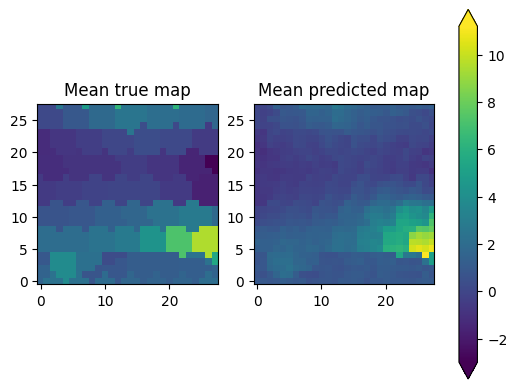

In [ ]:
vmin = -3
vmax = 11.2
plt.figure()

f, axarr = plt.subplots(1,2)

axarr[0].imshow(mean_map, origin="lower", vmin = vmin, vmax = vmax) #-3, 11.5
axarr[0].set_title('Mean true map')

axarr[1].imshow(pred_map, origin="lower", vmin = vmin, vmax = vmax)
axarr[1].set_title('Mean predicted map')

clb = f.colorbar(axarr[0].imshow(mean_map, origin="lower", vmin = vmin, vmax = vmax), ax=axarr, extend = 'both')

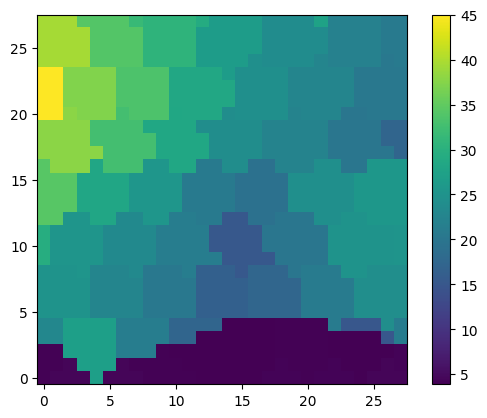

In [ ]:
plt.imshow(range_map, origin = "lower")
plt.colorbar()

RMSE map

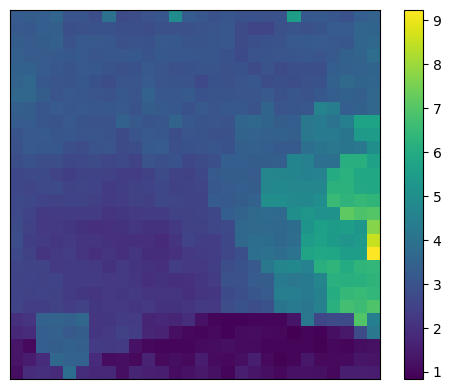

In [ ]:
sum_of_squares=(best_prediction - true_values)**2
mse = np.mean(sum_of_squares, axis = 0)
rmse = np.sqrt(mse)
fig = plt.imshow(rmse, origin="lower")
plt.colorbar()
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

NRMSE map

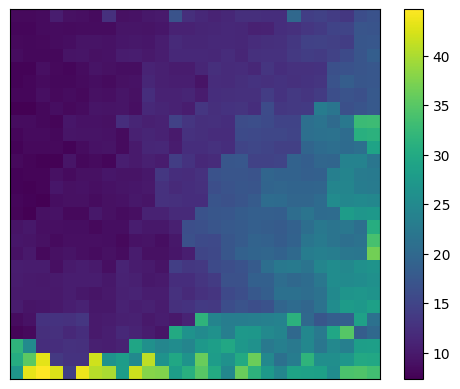

In [ ]:
nrmse = np.divide(rmse,range_map)*100
fig = plt.imshow(nrmse, origin="lower")
plt.colorbar()
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

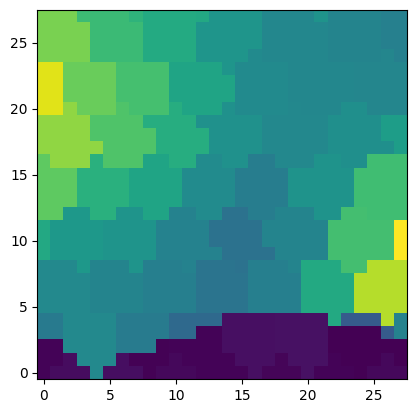

In [ ]:
grace_pixel_mean = np.mean(grace_norm['lwe_thickness'].values, axis = 0)
squares = (grace_ds['lwe_thickness'].values - grace_pixel_mean)**2
grace_ds_mse = np.mean(squares, axis = 0)
grace_ds_rmse = np.sqrt(grace_ds_mse)
plt.imshow(grace_ds_rmse, origin="lower")

In [ ]:
era5_names = list(era5_ds.keys())
era5_means = list()
era5_rmse = np.empty((len(era5_names),28,28))
era5_range = np.empty((len(era5_names),28,28))
era5_nrmse = np.empty((len(era5_names),28,28))
era5_nrmse_mean = np.empty((len(era5_names),28,28))

for i in range(0,len(era5_names)):
  era5_means.append(np.mean(era5_std[era5_names[i]].values, axis = 0))
  era_squares = (era5_std[era5_names[i]].values - era5_means[i])**2
  era5_rmse[i] = np.sqrt(np.mean(era_squares,axis = 0))
  era5_range[i] = ((np.max(era5_std[era5_names[i]].values, axis = 0)) - (np.min(era5_std[era5_names[i]].values, axis = 0)) )
  era5_nrmse[i] = np.divide(era5_rmse[i],era5_range[i])*100
  era5_nrmse_mean[i] = np.divide(era5_rmse[i],era5_means[i])*100

<ipython-input-150-33ef2296ac00>:13: RuntimeWarning: divide by zero encountered in divide
  era5_nrmse[i] = np.divide(era5_rmse[i],era5_range[i])*100


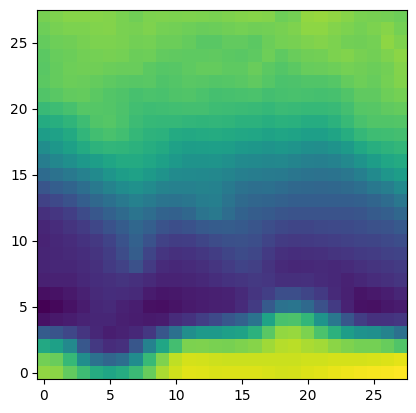

In [ ]:
plt.imshow(np.mean(era5_rmse, axis = 0), origin="lower")

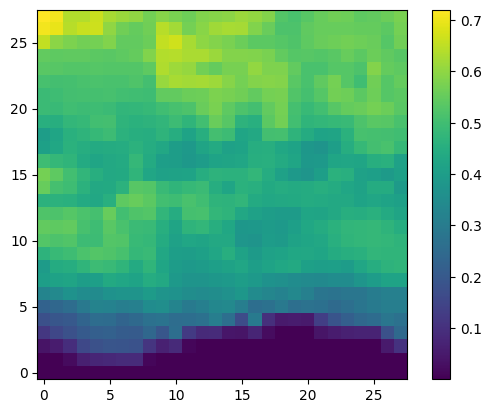

In [ ]:
plt.imshow(era5_rmse[7], origin="lower")
plt.colorbar()

# Save rasters

Take the images from 2016-11 to 2017-2 (-8 to -5); 2015-12 2016-03 (-19 to -16)

In [ ]:
sel_month = -16

In [ ]:
true_grace = copy.deepcopy(grace_ds['lwe_thickness'][sel_month])

true_grace = true_grace.rename({'time':'z' , 'lon':'x' , 'lat':'y'})
#true_grace = true_grace.rio.write_crs("WGS84")
true_grace = true_grace.drop_vars(['z','spatial_ref'])
del true_grace.attrs['grid_mapping']

In [ ]:
predicted_grace=xarray.DataArray(
                data = Y_pred_rescaled[sel_month,:,:,0],
                dims = ["y","x"],
                coords= dict(y = ("y", true_grace.coords["y"].values),
                             x = ("x", true_grace.coords["x"].values))
                )

In [ ]:
mean_nrmse_grace=xarray.DataArray(
                data = nrmse,
                dims = ["y","x"],
                coords= dict(y = ("y", true_grace.coords["y"].values),
                             x = ("x", true_grace.coords["x"].values))
                )

In [ ]:
true_grace.rio.to_raster('/gdrive/MyDrive/Sensors/Data/GRACE/grace_'+str(sel_month)+'.tif')

In [ ]:
predicted_grace.rio.to_raster('/gdrive/MyDrive/Sensors/Data/GRACE/grace_pred_'+str(sel_month)+'.tif')

In [ ]:
mean_nrmse_grace.rio.to_raster('/gdrive/MyDrive/Sensors/Data/GRACE/grace_nrmse-range_normalized.tif')

# Test and error maps with CI boundaries

In [ ]:
import fiona
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
import matplotlib as mpl
from descartes import PolygonPatch

In [ ]:
# with GEOPANDAS
CI_bounds = gpd.read_file("/gdrive/MyDrive/Sensors/Data/GRACE/shapefile_CI/civ_admbnda_adm0_cntig_20180706.shp")

In [ ]:
grace_CI_8 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_-8.tif")
grace_CI_7 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_-7.tif")
grace_CI_6 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_-6.tif")
grace_CI_5 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_-5.tif")

grace_CI_19 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_-19.tif")
grace_CI_18 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_-18.tif")
grace_CI_17 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_-17.tif")
grace_CI_16 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_-16.tif")


grace_pred_CI_8 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_pred_-8.tif")
grace_pred_CI_7 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_pred_-7.tif")
grace_pred_CI_6 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_pred_-6.tif")
grace_pred_CI_5 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_pred_-5.tif")

grace_pred_CI_19 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_pred_-19.tif")
grace_pred_CI_18 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_pred_-18.tif")
grace_pred_CI_17 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_pred_-17.tif")
grace_pred_CI_16 = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_pred_-16.tif")

grace_CI_nrmse = rasterio.open("/gdrive/MyDrive/Sensors/Data/GRACE/grace_nrmse-range_normalized.tif")

In [ ]:
nrmse_crop = rasterio.mask.mask(grace_CI_nrmse, CI_bounds['geometry'], crop=False)

In [ ]:
grace_CI_nrmse.read(1).max()

44.70117155689542

In [ ]:
nrmse_crop[0].max()

31.642076800044077

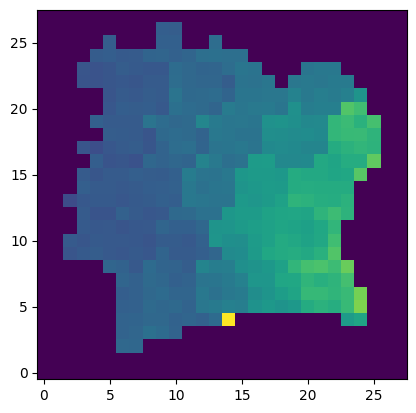

In [ ]:
plt.imshow(nrmse_crop[0][0], origin = 'lower')

Text(0.5, 1.0, 'TWSA [cm]')

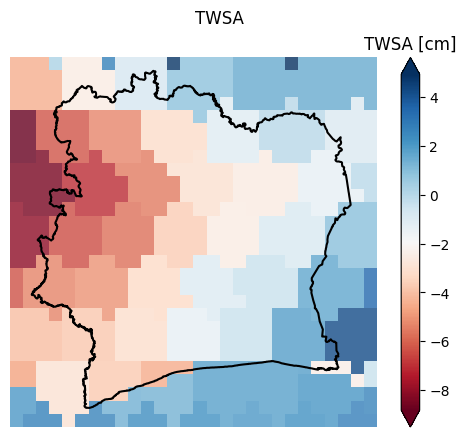

In [ ]:
fig, ax = plt.subplots()

fig.suptitle('TWSA')

xlim = ([-9.0,-2.0])
ylim = ([4.0,11.0])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()

image_hidden = ax.imshow(grace_CI_5.read(1), cmap='RdBu')

image = rasterio.plot.show(
  grace_CI_5,
  ax=ax,
  alpha = 0.8,
  cmap = 'RdBu'
  )

boundaries = CI_bounds.boundary.plot(
  ax = ax,
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

clb = fig.colorbar(image_hidden, ax=ax, extend = 'both')
clb.ax.set_title('TWSA [cm]')

In [ ]:
print(grace_CI_5.read(1).max())
print(grace_pred_CI_5.read(1).max())

4.9454474
14.199047


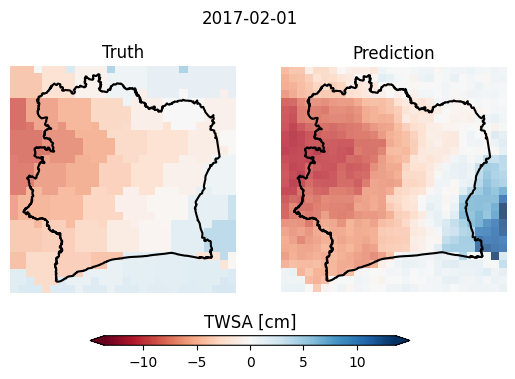

In [ ]:
fig, (true, pred) = plt.subplots(1,2)

fig.suptitle('2017-02-01', y=0.85)

vmin = -13.60
vmax = 13.60

xlim = ([-9.0,-2.0])
ylim = ([4.0,11.0])

true.set_xlim(xlim)
true.set_ylim(ylim)
true.set_axis_off()

pred.set_xlim(xlim)
pred.set_ylim(ylim)
pred.set_axis_off()

true.set_title('Truth')
rasterio.plot.show(
  grace_CI_5,
  ax=true,
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = true,
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )


pred.set_title('Prediction')

rasterio.plot.show(
  grace_pred_CI_5,
  ax=pred,
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = pred,
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )


clb = fig.colorbar(pred.imshow(grace_pred_CI_5.read(1), cmap='RdBu', vmin = vmin, vmax = vmax),
                   cax=plt.axes([0.25, 0.15, 0.5, 0.02]),
                   location = 'bottom', extend = 'both')
clb.ax.set_title('TWSA [cm]')
plt.show()

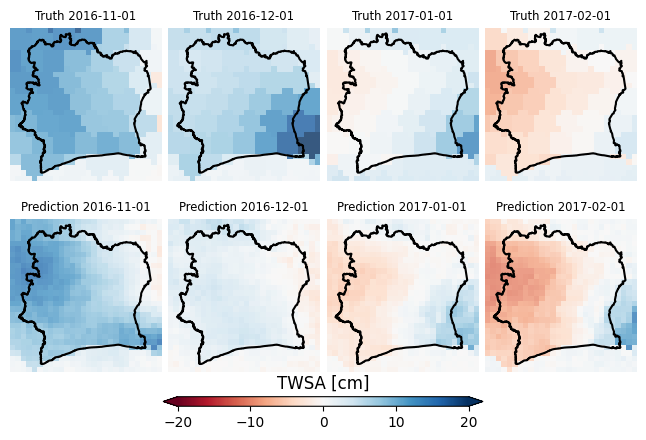

In [ ]:
fig, plots = plt.subplots(2,4)

vmin = -20
vmax = 20

xlim = ([-9.0,-2.0])
ylim = ([4.0,11.0])

for i in range(0,2):
  for j in range(0,4):
    plots[i,j].set_xlim(xlim)
    plots[i,j].set_ylim(ylim)
    plots[i,j].set_axis_off()

# 2016-11
plots[0,0].set_title('Truth 2016-11-01', fontsize = 'small')
rasterio.plot.show(
  grace_CI_8,
  ax=plots[0,0],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[0,0],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plots[1,0].set_title('Prediction 2016-11-01', fontsize = 'small')
rasterio.plot.show(
  grace_pred_CI_8,
  ax=plots[1,0],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[1,0],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )


# 2016-12
plots[0,1].set_title('Truth 2016-12-01', fontsize = 'small')
rasterio.plot.show(
  grace_CI_7,
  ax=plots[0,1],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[0,1],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plots[1,1].set_title('Prediction 2016-12-01', fontsize = 'small')
rasterio.plot.show(
  grace_pred_CI_7,
  ax=plots[1,1],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[1,1],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

# 2017-01
plots[0,2].set_title('Truth 2017-01-01', fontsize = 'small')
rasterio.plot.show(
  grace_CI_6,
  ax=plots[0,2],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[0,2],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plots[1,2].set_title('Prediction 2017-01-01', fontsize = 'small')
rasterio.plot.show(
  grace_pred_CI_6,
  ax=plots[1,2],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[1,2],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )


# 2017-02
plots[0,3].set_title('Truth 2017-02-01', fontsize = 'small')
rasterio.plot.show(
  grace_CI_5,
  ax=plots[0,3],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[0,3],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plots[1,3].set_title('Prediction 2017-02-01', fontsize = 'small')
rasterio.plot.show(
  grace_pred_CI_5,
  ax=plots[1,3],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[1,3],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plt.subplots_adjust(hspace=-0.3)
fig.tight_layout(pad=0.5)

clb = fig.colorbar(pred.imshow(grace_pred_CI_5.read(1), cmap='RdBu', vmin = vmin, vmax = vmax),
                   cax=plt.axes([0.25, 0.07, 0.5, 0.02]),
                   location = 'bottom', extend = 'both')
clb.ax.set_title('TWSA [cm]')
plt.show()

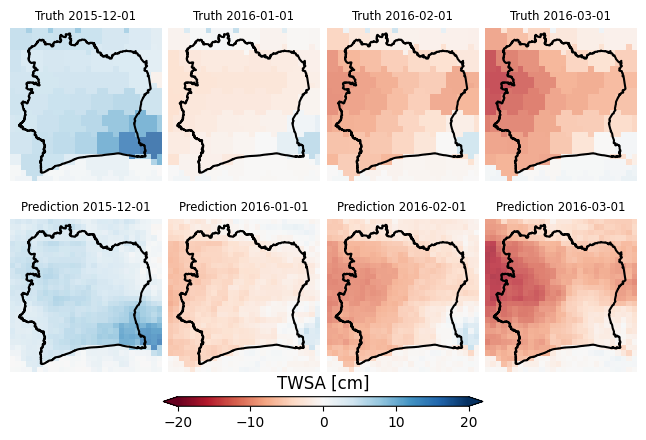

In [ ]:
fig, plots = plt.subplots(2,4)

vmin = -20
vmax = 20

xlim = ([-9.0,-2.0])
ylim = ([4.0,11.0])

for i in range(0,2):
  for j in range(0,4):
    plots[i,j].set_xlim(xlim)
    plots[i,j].set_ylim(ylim)
    plots[i,j].set_axis_off()

# 2016-11
plots[0,0].set_title('Truth 2015-12-01', fontsize = 'small')
rasterio.plot.show(
  grace_CI_19,
  ax=plots[0,0],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[0,0],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plots[1,0].set_title('Prediction 2015-12-01', fontsize = 'small')
rasterio.plot.show(
  grace_pred_CI_19,
  ax=plots[1,0],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[1,0],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )


# 2016-12
plots[0,1].set_title('Truth 2016-01-01', fontsize = 'small')
rasterio.plot.show(
  grace_CI_18,
  ax=plots[0,1],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[0,1],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plots[1,1].set_title('Prediction 2016-01-01', fontsize = 'small')
rasterio.plot.show(
  grace_pred_CI_18,
  ax=plots[1,1],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[1,1],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

# 2017-01
plots[0,2].set_title('Truth 2016-02-01', fontsize = 'small')
rasterio.plot.show(
  grace_CI_17,
  ax=plots[0,2],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[0,2],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plots[1,2].set_title('Prediction 2016-02-01', fontsize = 'small')
rasterio.plot.show(
  grace_pred_CI_17,
  ax=plots[1,2],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[1,2],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )


# 2017-02
plots[0,3].set_title('Truth 2016-03-01', fontsize = 'small')
rasterio.plot.show(
  grace_CI_16,
  ax=plots[0,3],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[0,3],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plots[1,3].set_title('Prediction 2016-03-01', fontsize = 'small')
rasterio.plot.show(
  grace_pred_CI_16,
  ax=plots[1,3],
  alpha = 0.8,
  cmap = 'RdBu',
  vmin = vmin,
  vmax = vmax
  )

CI_bounds.boundary.plot(
  ax = plots[1,3],
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

plt.subplots_adjust(hspace=-0.3)
fig.tight_layout(pad=0.5)

clb = fig.colorbar(pred.imshow(grace_pred_CI_16.read(1), cmap='RdBu', vmin = vmin, vmax = vmax),
                   cax=plt.axes([0.25, 0.07, 0.5, 0.02]),
                   location = 'bottom', extend = 'both')
clb.ax.set_title('TWSA [cm]')
plt.show()

Text(0.5, 1.0, 'NRMSE [%]')

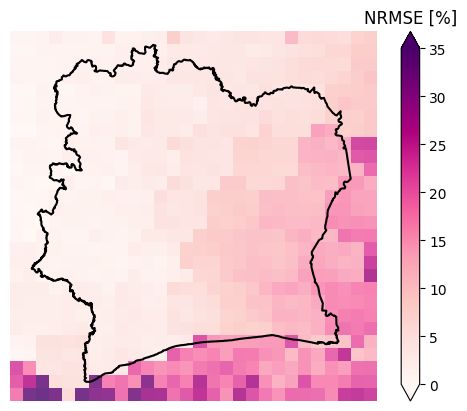

In [ ]:
fig, ax = plt.subplots()


xlim = ([-9.0,-2.0])
ylim = ([4.0,11.0])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()

image_hidden = ax.imshow(grace_CI_nrmse.read(1), cmap='RdPu', vmin = 0, vmax = 35)


image = rasterio.plot.show(
  grace_CI_nrmse,
  ax=ax,
  alpha = 0.8,
  cmap = 'RdPu'
  )

boundaries = CI_bounds.boundary.plot(
  ax = ax,
  color = 'Black',
  alpha = 1,
  linewidth = 1.5
  )

clb = fig.colorbar(image_hidden, ax=ax, extend = 'both')
clb.ax.set_title('NRMSE [%]')